# EEG Data Processing and Analysis Pipeline for Neurofeedback Experiments

### Author: Michael Zhou (mgz2112)

## 1. Loading and Visualizing EEG Data

Load and analyze EEG data from multiple `.mat` files. Each file contains raw EEG signals collected from various neurofeedback VR flight experiments. 

1. **Load EEG data**: Start by reading EEG data using the `h5py` library, which allows us to access and extract information from MATLAB `.mat` files. The EEG data is stored as a matrix where the rows represent different time points, and the columns represent channels.
2. **Reshape data**: To ensure consistency, we check the shape of the loaded data. If necessary, the data is transposed so that the format aligns with `(channels x time points)`. This reshaping standardizes the data for further analysis.
3. **Visualize data**: For initial exploration, we plot the first 1000 time points of two EEG channels. These plots provide a quick visual check of signal amplitude and variability, helping identify potential noise or artifacts.
4. **Event handling**: Alongside the EEG signals, each file contains event markers that denote specific experimental events (e.g., stimulus presentation or user responses). We extract and decode these events to analyze their types and corresponding time points. A sample of these events is printed to give a sense of the experimental context.
5. **Categorize data**: The files are divided into three experimental conditions: Baseline, Open Loop, and Closed Loop. This categorization allows us to systematically process and analyze data across different experimental phases.

By loading and visualizing EEG data in this manner, we prepare the dataset for subsequent preprocessing and analysis steps, including filtering, epoch extraction, and artifact removal.

In [11]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from mne.preprocessing import ICA
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
import gc
from joblib import Parallel, delayed


--- Baseline Files Analysis ---
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_B_RWEO_PreOL.mat
EEG Data Shape (Time Steps x Channels): (16240, 144)
Transposed EEG Data Shape (Channels x Time): (144, 16240)


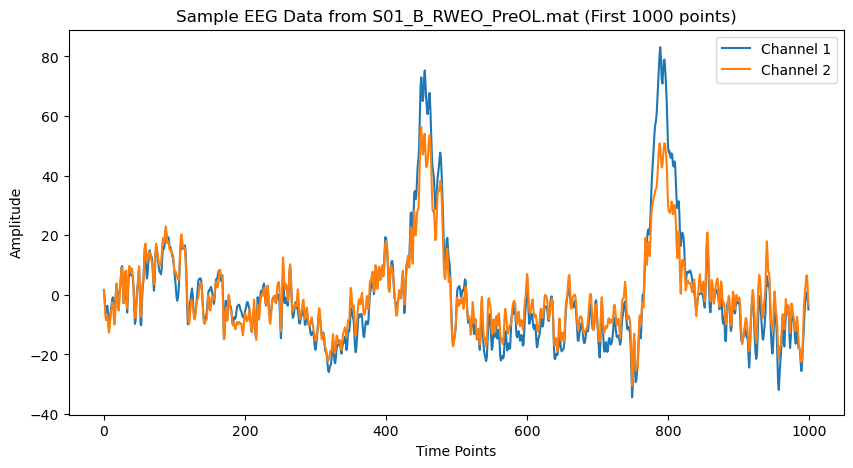

Sample Event Labels from S01_B_RWEO_PreOL.mat:
Type: EBlnk-Int-On, Latency: [330.]
Type: QRS, Latency: [428.]
Type: QRS-B_RWEO_PreOL, Latency: [428.]
Type: EBlnk-On, Latency: [458.]
Type: EBlnk-Off, Latency: [484.]
Type: EBlnk-Int-Off, Latency: [612.]
Type: EBlnk-Int-On, Latency: [671.]
Type: QRS, Latency: [684.]
Type: QRS-B_RWEO_PreOL, Latency: [684.]
Type: EBlnk-On, Latency: [799.]
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_D_RWEO_PstOL.mat
EEG Data Shape (Time Steps x Channels): (16637, 144)
Transposed EEG Data Shape (Channels x Time): (144, 16637)


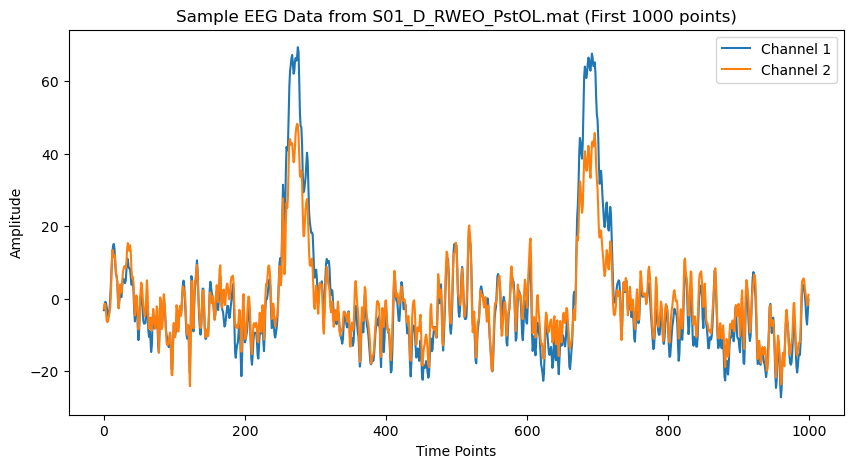

Sample Event Labels from S01_D_RWEO_PstOL.mat:
Type: EBlnk-Int-On, Latency: [154.]
Type: EBlnk-On, Latency: [282.]
Type: EBlnk-Off, Latency: [290.]
Type: QRS, Latency: [377.]
Type: QRS-D_RWEO_PstOL, Latency: [377.]
Type: EBlnk-Int-Off, Latency: [418.]
Type: EBlnk-Int-On, Latency: [567.]
Type: QRS, Latency: [636.]
Type: QRS-D_RWEO_PstOL, Latency: [636.]
Type: EBlnk-On, Latency: [695.]
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_E_RWEO_PreCL.mat
EEG Data Shape (Time Steps x Channels): (16513, 144)
Transposed EEG Data Shape (Channels x Time): (144, 16513)


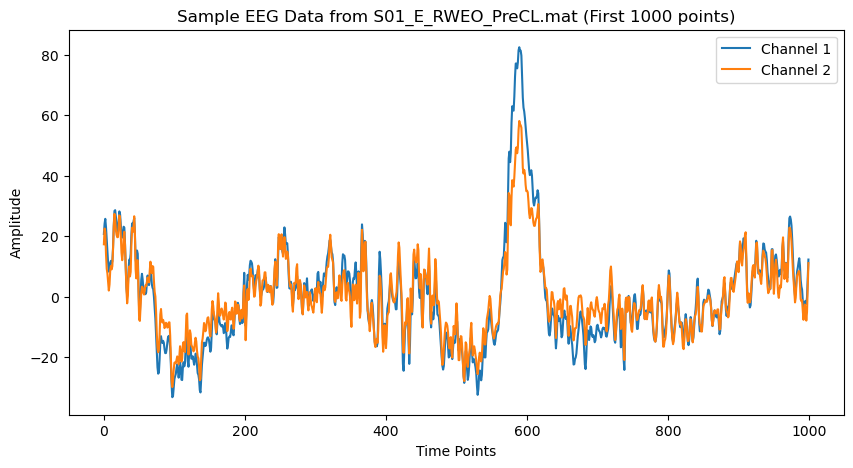

Sample Event Labels from S01_E_RWEO_PreCL.mat:
Type: EBlnk-Int-On, Latency: [1.]
Type: EBlnk-On, Latency: [1.]
Type: EBlnk-Off, Latency: [84.]
Type: EBlnk-Int-Off, Latency: [212.]
Type: QRS, Latency: [449.]
Type: QRS-E_RWEO_PreCL, Latency: [449.]
Type: EBlnk-Int-On, Latency: [461.]
Type: EBlnk-On, Latency: [589.]
Type: EBlnk-Off, Latency: [628.]
Type: QRS, Latency: [670.]
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_G_RWEO_PstCL.mat
EEG Data Shape (Time Steps x Channels): (16254, 144)
Transposed EEG Data Shape (Channels x Time): (144, 16254)


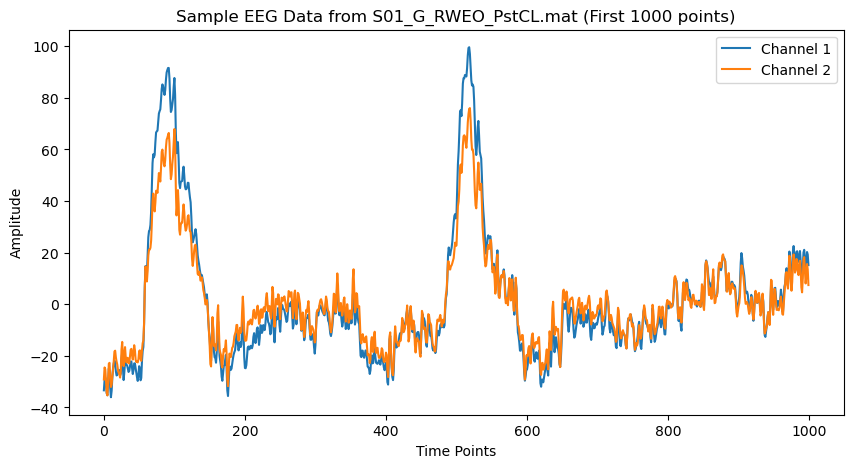

Sample Event Labels from S01_G_RWEO_PstCL.mat:
Type: EBlnk-Int-On, Latency: [1.]
Type: EBlnk-On, Latency: [82.]
Type: EBlnk-Off, Latency: [125.]
Type: EBlnk-Int-Off, Latency: [253.]
Type: QRS, Latency: [301.]
Type: QRS-G_RWEO_PstCL, Latency: [301.]
Type: EBlnk-Int-On, Latency: [386.]
Type: EBlnk-On, Latency: [514.]
Type: QRS, Latency: [524.]
Type: QRS-G_RWEO_PstCL, Latency: [524.]

--- Open Loop Files Analysis ---
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_C_OLoop.mat
EEG Data Shape (Time Steps x Channels): (139536, 144)
Transposed EEG Data Shape (Channels x Time): (144, 139536)


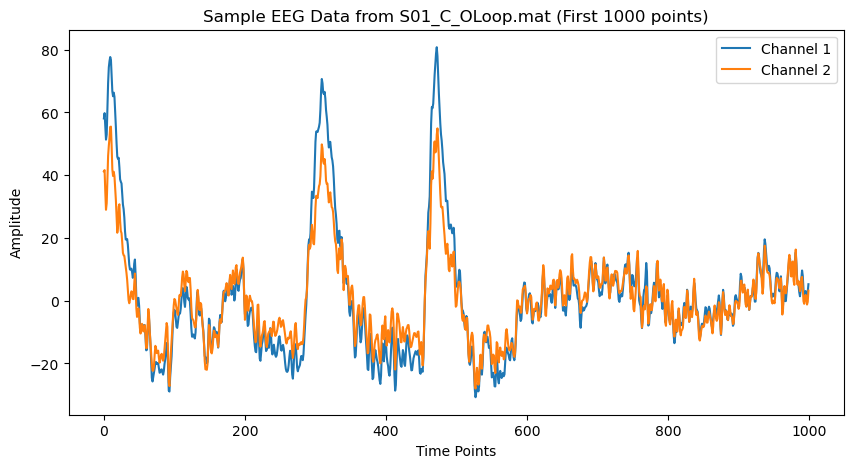

Sample Event Labels from S01_C_OLoop.mat:
Type: EBlnk-Int-On, Latency: [1.]
Type: EBlnk-On, Latency: [1.]
Type: EBlnk-Off, Latency: [51.]
Type: EBlnk-Int-On, Latency: [174.]
Type: EBlnk-Int-Off, Latency: [179.]
Type: EBlnk-On, Latency: [302.]
Type: EBlnk-Off, Latency: [354.]
Type: EBlnk-Int-On, Latency: [355.]
Type: QRS, Latency: [465.]
Type: QRS-C_OLoop, Latency: [465.]

--- Closed Loop Files Analysis ---
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_F_CL_Sil_50_100.mat
EEG Data Shape (Time Steps x Channels): (441421, 144)
Transposed EEG Data Shape (Channels x Time): (144, 441421)


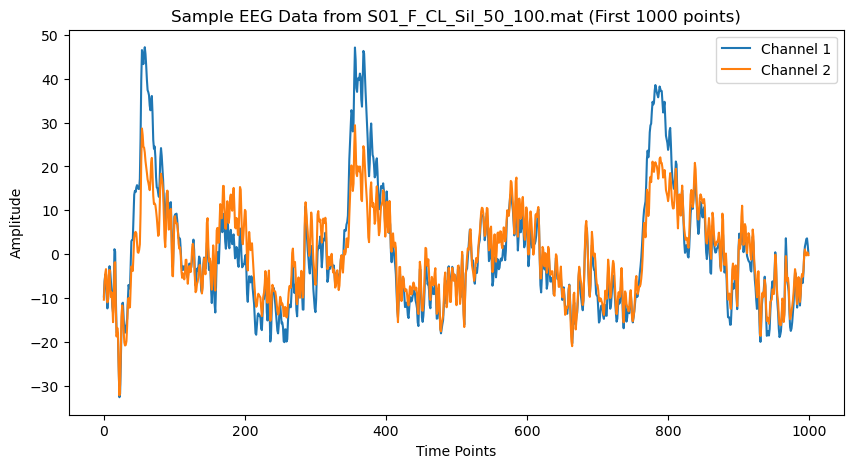

Sample Event Labels from S01_F_CL_Sil_50_100.mat:
Type: EBlnk-Int-On, Latency: [1.]
Type: EBlnk-On, Latency: [59.]
Type: EBlnk-Off, Latency: [106.]
Type: Art_HBeat_Audio_Onset, Latency: [152.329]
Type: EBlnk-Int-Off, Latency: [234.]
Type: EBlnk-Int-On, Latency: [234.]
Type: EBlnk-On, Latency: [362.]
Type: QRS, Latency: [368.]
Type: QRS-F_CL_Sil_50_100, Latency: [368.]
Type: EBlnk-Off, Latency: [417.]
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_F_CL_Sil_50_100.mat
EEG Data Shape (Time Steps x Channels): (441421, 144)
Transposed EEG Data Shape (Channels x Time): (144, 441421)


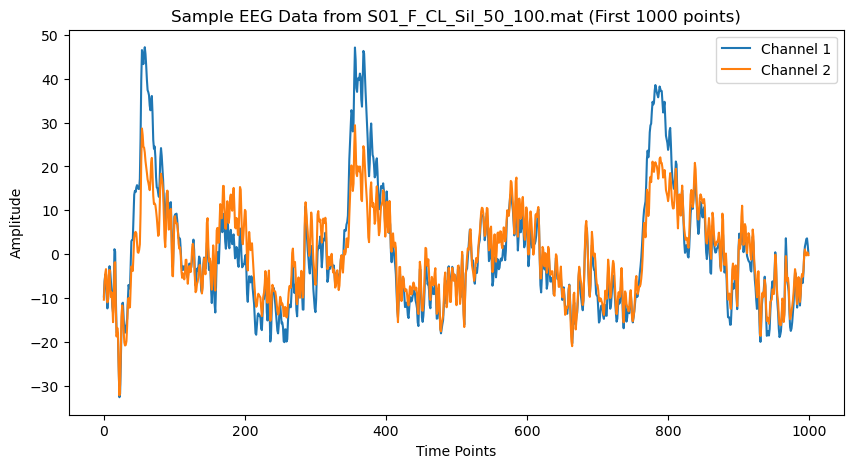

Sample Event Labels from S01_F_CL_Sil_50_100.mat:
Type: EBlnk-Int-On, Latency: [1.]
Type: EBlnk-On, Latency: [59.]
Type: EBlnk-Off, Latency: [106.]
Type: Art_HBeat_Audio_Onset, Latency: [152.329]
Type: EBlnk-Int-Off, Latency: [234.]
Type: EBlnk-Int-On, Latency: [234.]
Type: EBlnk-On, Latency: [362.]
Type: QRS, Latency: [368.]
Type: QRS-F_CL_Sil_50_100, Latency: [368.]
Type: EBlnk-Off, Latency: [417.]


In [2]:
def load_and_analyze_eeg(file_path):
    with h5py.File(file_path, 'r') as f:
        # Access EEG data and display shape
        eeg_data = np.array(f['actualVariable']['EEG_full']['data'])
        print(f"Loaded file: {file_path}")
        print(f"EEG Data Shape (Time Steps x Channels): {eeg_data.shape}")
        
        # Ensure data is correctly shaped as (channels, time_steps)
        if eeg_data.shape[1] == 144:  # If shape is (time_steps, channels)
            eeg_data = eeg_data.T  # Transpose to (channels, time_steps)
        
        print(f"Transposed EEG Data Shape (Channels x Time): {eeg_data.shape}")
        
        # Plot first two channels for a visual check
        plt.figure(figsize=(10, 5))
        plt.plot(eeg_data[0, :1000], label='Channel 1')
        plt.plot(eeg_data[1, :1000], label='Channel 2')
        plt.title(f"Sample EEG Data from {os.path.basename(file_path)} (First 1000 points)")
        plt.xlabel("Time Points")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()
        
        # Correct event markers handling
        events = f['actualVariable']['EEG_full']['event']
        event_labels = []
        
        for i in range(len(events['type'])):
            # Dereference 'type' and 'latency' using h5py
            event_type_ref = events['type'][i][0]
            event_latency_ref = events['latency'][i][0]
            
            # Read the referenced data
            event_type = ''.join(chr(x) for x in f[event_type_ref][:].flatten())
            event_latency = f[event_latency_ref][()][0]
            event_labels.append((event_type, event_latency))
        
        print(f"Sample Event Labels from {os.path.basename(file_path)}:")
        for event in event_labels[:10]:  # Display first 10 event labels
            print(f"Type: {event[0]}, Latency: {event[1]}")

# Define file paths for EEG categories

# Baseline (RWEO) files
baseline_files = [
    'S01_B_RWEO_PreOL.mat', 'S01_D_RWEO_PstOL.mat',
    'S01_E_RWEO_PreCL.mat', 'S01_G_RWEO_PstCL.mat'
]

# Open-Loop Calibration (OLoop) files
open_loop_files = ['S01_C_OLoop.mat']

# Closed-Loop Feedback (CLoop and Feedback conditions)
closed_loop_files = [
    'S01_F_CL_Sil_50_100.mat', 'S01_F_CL_Sil_50_100.mat'
]

# Define the base directory
base_dir = 'Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/' 

# Run analysis on each category
for category, file_list in [('Baseline', baseline_files), 
                            ('Open Loop', open_loop_files), 
                            ('Closed Loop', closed_loop_files)]:
    print(f"\n--- {category} Files Analysis ---")
    for file_name in file_list:
        full_path = os.path.join(base_dir, file_name)
        load_and_analyze_eeg(full_path)

## 2. Preprocessing and Analyzing EEG Data: Filtering, Epoch Extraction, and Artifact Removal

We now perform preprocessing on the data below. The pipeline consists of the following steps:
1. **Filter data**:
   - A Butterworth filter is implemented to perform band-pass filtering, allowing only frequencies within a specific range to pass (1-40 Hz). This step helps remove noise and focus on relevant brain activity signals.
   - A high-pass filter is also applied when needed to meet the requirements for Independent Component Analysis (ICA).
2. **Reshape and preprocess data**:
   - Raw EEG data is loaded from `.mat` files using `h5py` and reshaped to ensure consistency in format `(channels x time points)`.
   - Preprocessing steps like NaN and infinite value handling are performed to prepare the data for further analysis.
3. **Extract epochs**:
   - The EEG data is segmented into epochs around specific event markers, defined by experimental conditions. Each epoch represents brain activity surrounding a particular event, allowing for more targeted analysis.
4. **Remove artifacts with ICA**:
   - Independent Component Analysis (ICA) is used to identify and remove artifacts, such as eye movements or muscle activity, from the EEG signals.
   - High-pass filtered epochs are fed into the ICA model to ensure accurate component separation.
5. **Time-Frequency Analysis**:
   - A time-frequency representation of the EEG data is computed using Morlet wavelet transforms. This provides insights into the power of different frequency bands over time, helping to capture dynamic changes in brain activity.
6. **Batch Processing and Memory Optimization**:
   - To handle large datasets efficiently, EEG data is processed in smaller batches. This reduces memory usage and prevents kernel crashes.
   - Garbage collection is used to free up memory after processing each batch.

In [ ]:
# Define Butterworth band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    if highcut is None:
        low = lowcut / nyquist
        b, a = butter(order, low, btype='high')
    else:
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)

# Load and preprocess EEG data
def load_and_preprocess_eeg(file_path, lowcut=1.0, highcut=40, fs=250):
    with h5py.File(file_path, 'r') as f:
        eeg_data = np.array(f['actualVariable']['EEG_full']['data'])
        if eeg_data.shape[1] == 144:
            eeg_data = eeg_data.T
        
        filtered_data = bandpass_filter(eeg_data, lowcut, highcut, fs)
        filtered_data = np.nan_to_num(filtered_data)
        print(f"Preprocessed EEG Data Shape: {filtered_data.shape}")
        
        # Extract events
        events = f['actualVariable']['EEG_full']['event']
        event_labels = []
        
        for i in range(len(events['type'])):
            event_type_ref = events['type'][i][0]
            event_latency_ref = events['latency'][i][0]
            event_type = ''.join(chr(x) for x in f[event_type_ref][:].flatten())
            event_latency = f[event_latency_ref][()][0]
            event_labels.append((event_type, event_latency))
        
        return filtered_data, event_labels

# Extract epochs around events
def epoch_eeg_data(eeg_data, event_labels, batch_start, batch_end, epoch_start=-0.2, epoch_end=0.8, fs=250):
    epochs = []
    labels = []
    for etype, elatency in event_labels:
        elatency_relative = elatency - batch_start
        start = int((elatency_relative + epoch_start * fs))
        end = int((elatency_relative + epoch_end * fs))
        
        if start > 0 and end < eeg_data.shape[1]:
            epochs.append(eeg_data[:, start:end])
            labels.append(etype)
    
    epochs = np.array(epochs)
    print(f"Extracted {len(epochs)} epochs for batch range ({batch_start}, {batch_end})")
    return epochs, labels

# Run Independent Component Analysis (ICA) for artifact removal
def apply_ica(epochs, fs, max_components=10, max_iter=300):
    info = create_info(ch_names=[f'EEG {i+1}' for i in range(epochs.shape[1])], sfreq=fs, ch_types='eeg')
    ica = ICA(n_components=max_components, random_state=42, max_iter=max_iter, verbose=False)
    
    # High-pass filter for ICA requirements
    epochs_highpass = bandpass_filter(epochs, lowcut=1.0, highcut=None, fs=fs)
    epochs_array = EpochsArray(epochs_highpass, info)
    
    ica.fit(epochs_array)
    print(f"Completed ICA.")
    
    return ica.apply(epochs_array).get_data()

# Time-Frequency Analysis
def time_frequency_analysis(epochs, sfreq=250, freqs=np.logspace(1, 2, 20)):
    power = []
    n_channels = epochs.shape[1]
    info = create_info(ch_names=[f'EEG {i+1}' for i in range(n_channels)], sfreq=sfreq, ch_types='eeg')
    for ep in epochs:
        tfr = tfr_morlet(EpochsArray([ep], info), freqs, n_cycles=2, return_itc=False)
        power.append(tfr.data)
    print(f"Completed Time-Frequency Analysis.")
    return np.array(power)

def downsample_eeg(eeg_data, factor=2):
    return eeg_data[:, ::factor]  # Reduces the number of time points

# Process EEG files in smaller batches
def process_eeg_files_in_batches(file_list, base_dir, batch_size=5000):
    for file_name in file_list:
        full_path = os.path.join(base_dir, file_name)
        print(f"Processing file: {file_name}")
        eeg_data, event_labels = load_and_preprocess_eeg(full_path)
        
        for i in range(0, eeg_data.shape[1], batch_size):
            batch_end = min(i + batch_size, eeg_data.shape[1])
            eeg_batch = eeg_data[:, i:batch_end]
            epochs, labels = epoch_eeg_data(eeg_batch, event_labels, i, batch_end)
            if epochs.size == 0:
                print(f"No valid epochs in batch {i // batch_size + 1}. Skipping...")
                continue
            
            # Parallelized ICA and Time-Frequency Analysis
            Parallel(n_jobs=-1)([
                delayed(apply_ica)(epochs, fs=250),
                delayed(time_frequency_analysis)(epochs)
            ])
            print(f"Finished processing batch {i // batch_size + 1} of file {file_name}")
            del eeg_batch, epochs
            gc.collect()

# Define file paths and categories
baseline_files = ['S01_B_RWEO_PreOL.mat', 'S01_D_RWEO_PstOL.mat']
open_loop_files = ['S01_C_OLoop.mat']
closed_loop_files = ['S01_F_CL_Sil_50_100.mat']

base_dir = 'Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/' 

# Run for all files in a loop
for category, file_list in [('Baseline', baseline_files), 
                            ('Open Loop', open_loop_files), 
                            ('Closed Loop', closed_loop_files)]:
    print(f"\n--- {category} Files Analysis ---")
    process_eeg_files_in_batches(file_list, base_dir)


--- Baseline Files Analysis ---
Processing file: S01_B_RWEO_PreOL.mat
Preprocessed EEG Data Shape: (144, 16240)
Extracted 70 epochs for batch range (0, 5000)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
N

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: Using n_components=10 (resulting in n_components_=10) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.4e+02) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 6
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: Using n_components=10 (resulting in n_components_=10) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.4e+02) and smallest (1.8e-07) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 3
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: Using n_components=10 (resulting

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Finished processing batch 7 of file S01_C_OLoop.mat
Extracted 153 epochs for batch range (35000, 40000)
Completed Time-Frequency Analysis.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: Using n_components=10 (resulting in n_components_=10) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.4e+02) and smallest (7.1e-07) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 3
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: Fas

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Finished processing batch 18 of file S01_C_OLoop.mat
Extracted 206 epochs for batch range (90000, 95000)
Completed Time-Frequency Analysis.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
206 matching events found
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
No baseline correction applied
0 projection items activated
Fitting ICA to data using 144 channels (please be patient, this may take a while)
Not setting metadata
1 matching events fo

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: Using n_components=10 (resulting in n_components_=10) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.4e+02) and sm

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA took 2.0s.
Completed ICA.
Applying ICA to Epochs instance
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 144 PCA components
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction app

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
169 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA to data using 144 channels (please be patient, this may take a while)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activ

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA took 2.2s.
Completed ICA.
Applying ICA to Epochs instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 144 PCA components
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction app

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Finished processing batch 5 of file S01_F_CL_Sil_50_100.mat
Extracted 176 epochs for batch range (25000, 30000)
Completed Time-Frequency Analysis.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Completed Time-Frequency Analysis.
Not setting metadata
176 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA to data using 144 channels (please be patient, this may take a while)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Selecting by number: 10 components
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: Using n_components=10 (resulting in n_components_=10) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.4e+02) and smallest (1.7e-08) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 2
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Finished processing batch 18 of file S01_F_CL_Sil_50_100.mat
Extracted 170 epochs for batch range (90000, 95000)
Completed Time-Frequency Analysis.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Completed Ti

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: Using n_components=10 (resulting in n_components_=10) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.4e+02) and smallest (7e-15) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 1
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: Using n_components=10 (resulting in n_components_=10) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.4e+02) and smallest (4.3e-14) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 1
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: Using n_components=10 (resulting in n_components_=10) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.4e+02) and smallest (4.1e-08) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 2
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: Fas

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Selecting by number: 10 components
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA took 3.2s.
Completed ICA.
Applying ICA to Epochs instance
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 144 PCA components
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction app

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_25211/2563664442.py:63: RuntimeWarning: Using n_components=10 (resulting in n_components_=10) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.4e+02) and smallest (3.1e-08) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 3
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Completed Time-Frequency Analysis.
Not setting metadata
206 matching events found
No baseline correction applied
Not setting metadata
1 matching events found
0 projection items activated
No baseline correction applied
0 projection items activated
Fitting ICA to data using 144 channels (please be patient, this may take a while)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events fo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Finished processing batch 65 of file S01_F_CL_Sil_50_100.mat
Extracted 157 epochs for batch range (325000, 330000)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Selecting by number: 10 components
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA took 2.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Selecting by number: 10 components
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA took 2.0s.
Not setting metadata
1 matching events found
Completed ICA.
Applying ICA to Epochs instance
No baseline correction applied
0 projection items activated
    Transforming to ICA space (10 components)
    Zeroi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baselin

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Selecting by number: 10 components
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata